# MNIST Handwritten Digit Recognition in PyTorch

Example taken from:

* Main source: https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

* Complemented with: https://nextjournal.com/gkoehler/pytorch-mnist

* Application to recognise drawn digits: https://ashok.tanka.la/assets/examples/mnist/mnist.html

About variables and autograd, see: https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/

## Import PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

## Initialize Hyper-parameters

In [2]:
input_size = 784       # The image size = 28 x 28 = 784
hidden_size = 500      # The number of nodes at the hidden layer
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 5         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

## Download MNIST Dataset

In [3]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

## Load the Dataset

We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Let's take a look at some examples. 
We'll use the test_loader for this.

batch data: torch.Size([100, 1, 28, 28])


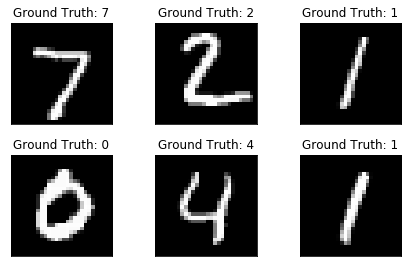

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Let's see what one test data batch consists of
# --> we have [batch_size] examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). 
print("batch data:", example_data.shape)

# Plot some examples with matplotlib
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
    
plt.show()

## Feedforward Neural Network Model using nn.Sequential

Use the nn package to define our model as a sequence of layers. nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

In [6]:
# Uncomment lines below for 2-layer NN
# net = torch.nn.Sequential(
#     torch.nn.Linear(input_size, hidden_size),     # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#     torch.nn.ReLU(),                              # Non-Linear ReLU Layer: max(0,x)
#     torch.nn.Linear(hidden_size, num_classes),    # Last Full-Connected Layer: 500 (hidden node) -> 10 (output class)
# )

### Exercice: implementation with two more layers

In [7]:
# Added two extra layers w.r.t default example
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),     # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
    torch.nn.ReLU(),                              # Non-Linear ReLU Layer: max(0,x)
    torch.nn.Linear(hidden_size, 250),            # Added extra Full-Connected Layer (test): 500 -> 250
    torch.nn.ReLU(),                              # Also with ReLU
    torch.nn.Linear(250,100),                     # Added extra Full-Connected Layer (test): 250 -> 100
    torch.nn.ReLU(),                              # Also with ReLU
    torch.nn.Linear(100, num_classes),            # Last Full-Connected Layer: 500 (hidden node) -> 10 (output class)
)

## Enable GPU 

In [8]:
# net.cuda()    # You can comment out this line to disable GPU

## Choose the Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# alternative Stochastic Gradient Descent (give worse results and needs 20xlr and 20 epochs)
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

## Train the FNN Model

Note: torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [11]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a matrix of 28 x 28 from to a vector of size 784 (view works as numpy's reshape function)
        labels = Variable(labels)        
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))
            
        if (i+1) % 10 == 0:                              # keep track of loss value
            train_losses.append(loss.item())
            train_counter.append(((i+1)*batch_size) + ((epoch)*len(train_loader.dataset)))

Epoch [1/5], Step [100/600], Loss: 0.4246
Epoch [1/5], Step [200/600], Loss: 0.4080
Epoch [1/5], Step [300/600], Loss: 0.1790
Epoch [1/5], Step [400/600], Loss: 0.1119
Epoch [1/5], Step [500/600], Loss: 0.1614
Epoch [1/5], Step [600/600], Loss: 0.0866
Epoch [2/5], Step [100/600], Loss: 0.0705
Epoch [2/5], Step [200/600], Loss: 0.0369
Epoch [2/5], Step [300/600], Loss: 0.0955
Epoch [2/5], Step [400/600], Loss: 0.0884
Epoch [2/5], Step [500/600], Loss: 0.0348
Epoch [2/5], Step [600/600], Loss: 0.0931
Epoch [3/5], Step [100/600], Loss: 0.0510
Epoch [3/5], Step [200/600], Loss: 0.1094
Epoch [3/5], Step [300/600], Loss: 0.0701
Epoch [3/5], Step [400/600], Loss: 0.0622
Epoch [3/5], Step [500/600], Loss: 0.0148
Epoch [3/5], Step [600/600], Loss: 0.0167
Epoch [4/5], Step [100/600], Loss: 0.0971
Epoch [4/5], Step [200/600], Loss: 0.0219
Epoch [4/5], Step [300/600], Loss: 0.0624
Epoch [4/5], Step [400/600], Loss: 0.0257
Epoch [4/5], Step [500/600], Loss: 0.0172
Epoch [4/5], Step [600/600], Loss:

## Test the FNN Model

Similar to training the nerual network, we also need to load batches of test images and collect the outputs. The differences are that:
(1) No loss & weights calculation
(2) No wights update
(3) Has correct prediction calculation

In [12]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 97 %


## Evaluating the Model's Performance

Text(0,0.5,'Loss')

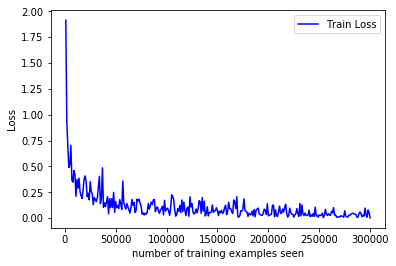

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')


In [14]:
# Save the model for future implementations
torch.save(net.state_dict(), 'fnn_model.pkl')